Plotting script for deep O2 bias manuscript

2022_07_21 Seth Bushinsky - will try to piggy-back off code being writting by Veronica Tamsitt & the rest of the Argo BGC bias adjustment project (Bushinsky, Nachod, Fassbender, Williams)


In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import glob, os
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from datetime import datetime, date, time
import time
from scipy import stats
import carbon_utils

Function for converting date to year fraction (taken from stack overflow: https://stackoverflow.com/questions/6451655/how-to-convert-python-datetime-dates-to-decimal-float-years)

In [2]:
def toYearFraction(date):
    def sinceEpoch(date): # returns seconds since epoch
        return time.mktime(date.timetuple())
    s = sinceEpoch

    year = date.year
    startOfThisYear = datetime(year=year, month=1, day=1)
    startOfNextYear = datetime(year=year+1, month=1, day=1)

    yearElapsed = s(date) - s(startOfThisYear)
    yearDuration = s(startOfNextYear) - s(startOfThisYear)
    fraction = yearElapsed/yearDuration

    return date.year + fraction

In [3]:
# read in a user-created text file to point to local directories to avoid having to change this every time 
# we update code
lines=[]
with open('path_file.txt') as f:
    lines = f.readlines()
    
count = 0
for line in lines:
    count += 1
    index = line.find("=")
    #print(f'line {count}: {line}')
    #print(index)
    #print(line[0:index])
    line = line.rstrip()
    if line[0:index].find("argo")>=0:
        argo_path=line[index+1:]
    elif line[0:index].find("liar")>=0:
        liar_dir=line[index+1:]
    elif line[0:index].find("matlab")>=0:
        matlab_dir=line[index+1:]
        
# Set the paths
output_dir = 'output/'
data_dir = 'data/'

In [4]:
output_dir_figs = 'figures_o2_bias/'

#check directories exist
if not os.path.isdir('figures_o2_bias'):
    os.mkdir('figures_o2_bias')

1. Read in all float Sprof files from argo path

In [ ]:
argolist = []
for file in os.listdir(argo_path):
    if file.endswith('Sprof.nc'):
        argolist.append(file)

last = 0

2. For each file, find all profiles with valid O2 data, save out lat/lon/date into an array

In [ ]:
#wmo_list = list()
for n in range(last, len(argolist)):
    print(f' {n}' ' File: ' + argolist[n]) 

    #n = 0
    argo_n = xr.load_dataset(argo_path+argolist[n])
    argo_n = argo_n.set_coords(('PRES_ADJUSTED','LATITUDE','LONGITUDE','JULD'))
    
    var_list = list(argo_n.data_vars)
    if "DOXY_ADJUSTED" not in var_list:
        print('Skipping')
        continue
            
    doxy_trimmed = argo_n.DOXY_ADJUSTED.where(~np.isnan(argo_n.DOXY_ADJUSTED), drop=True)
    wmo_n = argo_n.PLATFORM_NUMBER.values.astype(int)[0]

    prof_loc = xr.Dataset()
    prof_loc['wmo']=(['N_PROF'],np.repeat(wmo_n,len(doxy_trimmed)))

    prof_loc['LATITUDE'] = (['N_PROF'], doxy_trimmed.LATITUDE.data)
    prof_loc['LONGITUDE'] = (['N_PROF'], doxy_trimmed.LONGITUDE.data)
    prof_loc['juld'] = (['N_PROF'],doxy_trimmed.JULD.data)
    #prof_loc['profile'] = (['N_PROF'],doxy_trimmed.CYCLE_NUMBER.data)
    #argo_n
    # append all files into one long xarray
    if n == 0:
        argo_all = prof_loc
    else:
        argo_all = xr.concat([argo_all,prof_loc], 'N_PROF')

    last = n + 1
argo_all

Plotting

In [ ]:
# plotting all data
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.set_global()
plt.plot(argo_all.LONGITUDE, argo_all.LATITUDE, linestyle='none', marker='.', markersize=1)
plt.show()

In [ ]:
# Average data by wmo. Longitude is currently incorrectly averaged, which is fixed below
argo_wmo = argo_all.groupby('wmo').mean()

avg_date = argo_all.juld.astype('int64').groupby(argo_all['wmo']).mean().astype('datetime64[ns]')

# calculate the year fraction for plotting
avg_date_dec_year = []
for i in avg_date.values:
    x = pd.Timestamp(i)
    y = toYearFraction(x)
    avg_date_dec_year.append(y)

In [ ]:
for wmo in argo_wmo.wmo:
    temp_LONGITUDE = argo_all.LONGITUDE.where(argo_all.wmo==wmo, drop=True)
    if (np.max(temp_LONGITUDE) - np.min(temp_LONGITUDE))>300:
        print('YES')
        new_mean = np.mean(xr.where(temp_LONGITUDE>=0, temp_LONGITUDE, temp_LONGITUDE+360))
        if new_mean>180:
            new_mean = new_mean-360
            old_mean = argo_wmo.LONGITUDE.where(argo_wmo.wmo==wmo, drop=True)

        #print('old mean: '  + str(old_mean.values))
        #print('new mean: '  + str(new_mean.values))

        # put new LONGITUDE mean back into argo_wmo
        argo_wmo['LONGITUDE'] = argo_wmo.LONGITUDE.where(argo_wmo.wmo!=wmo, new_mean)
        #updated_mean = argo_wmo.LONGITUDE.where(argo_wmo.wmo==wmo, drop=True)

        #print('new mean: '  + str(updated_mean.values))

        #new_mean
    #else:
        #print('NO')

In [ ]:
# Figure 1

fig = plt.figure(figsize=(20,12))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.set_global()
sct = plt.scatter(x=argo_wmo.LONGITUDE, 
            y=argo_wmo.LATITUDE, 
            c=avg_date_dec_year,cmap='turbo',s=10)
cbar = plt.colorbar(sct, fraction=.08, pad = 0.04, shrink=0.5)
cbar.set_label('Year', labelpad=15, fontsize=14)
plt.savefig(output_dir_figs+ 'Fig_1_O2_float_map_date.png')
plt.show()


Alternate version of Figure 1: gridded observational density

In [ ]:
# Gridded density plot taken from J. Lilly's Distributional-Analysis code: http://www.jmlilly.net/course/labs/html/DistributionalAnalysis-Python.html
figsize=np.array([18, 12]);
projection=ccrs.PlateCarree();

cmap = plt.cm.get_cmap("Spectral_r", 64)

#for future reference, define a function to set up our map
def map_setup(figsize,projection):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(projection=projection)
    ax.add_feature(cfeature.LAND, facecolor='grey')
    gl = ax.gridlines(draw_labels=True)  
    gl
    gl.xlabel_style = {'size': 15}
    gl.ylabel_style = {'size': 15}
    return fig, ax 

fig, ax = map_setup(figsize,projection) 

dlatlon = 1
lonbins = np.arange(-180, 180, dlatlon)
latbins = np.arange(-80, 80, dlatlon)

hist = stats.binned_statistic_2d(argo_all.LATITUDE, argo_all.LONGITUDE, None, bins=[latbins, lonbins], statistic="count")
hist.statistic[hist.statistic == 0] = np.nan  # Sets all values of 0 to nan as log10(0) = -inf
hist.statistic

image = plt.pcolormesh(lonbins, latbins, hist.statistic, cmap=cmap, shading="flat", transform=ccrs.PlateCarree()) 
plt.clim(0, 100) 

cbar = fig.colorbar(image, ax=ax, orientation='horizontal', fraction=0.1, aspect=40, pad=0.08)
               
cbar.ax.tick_params(labelsize=20)
cbar.set_label(label='Number of Observations', size=20)
plt.savefig(output_dir_figs+ 'Fig_1v2_Argo_O2_Sampling_Density.png')

Figure 3. Histograms showing any bias in bgc parameters from crossovers with glodap


In [5]:
glodap_offsets_mean = xr.load_dataset(output_dir+'glodap_offsets_floatmean_withcalibration.nc')

In [6]:
glodap_offsets_p = glodap_offsets_mean.to_dataframe()

In [7]:
parameter_a = 'o2_calib_air_group'
parameter_b = 'pH_group'
offsets_g = glodap_offsets_p.groupby(parameter_a)

In [8]:
offsets_pH = glodap_offsets_p.groupby([parameter_a, parameter_b])

In [82]:
n[0]

'no cal/bad'

air cal
no air cal
no cal/bad
('air cal', 'pH')
('no air cal', 'pH')


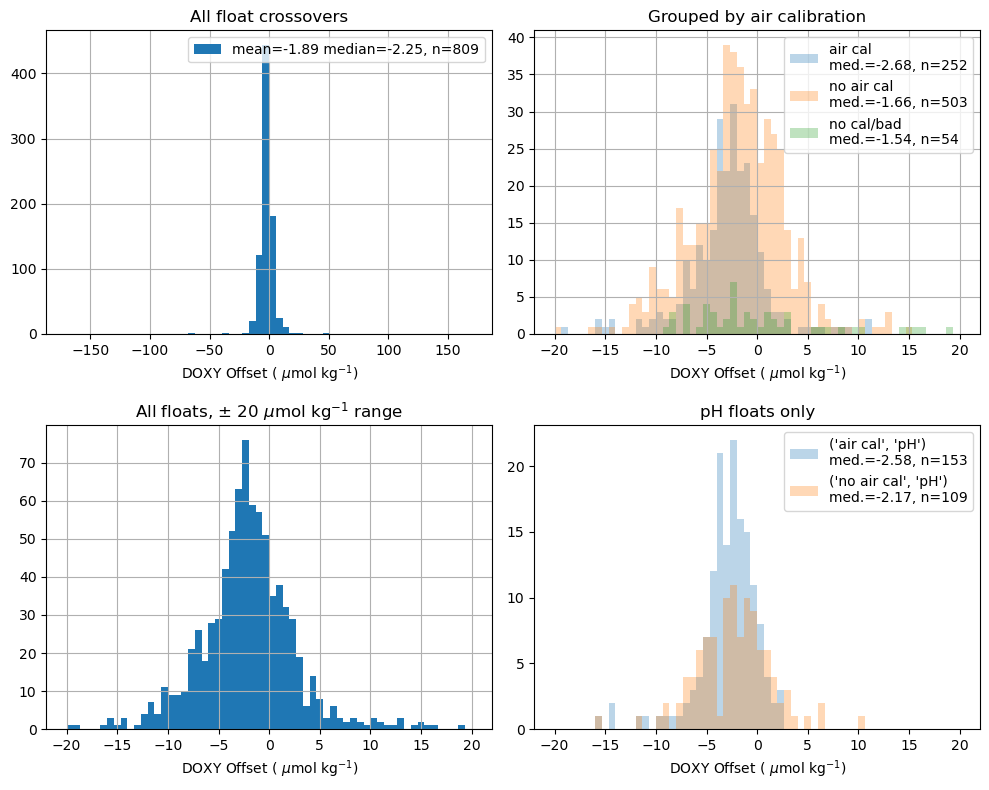

In [9]:

plt.figure(figsize=(10,8))
plt.subplot(2,2,1)
nmean = np.around(glodap_offsets_mean['DOXY_ADJUSTED_offset'].mean(), decimals=2)
nmedian = np.around(glodap_offsets_mean['DOXY_ADJUSTED_offset'].median(), decimals=2)
ncount = glodap_offsets_mean['DOXY_ADJUSTED_offset'].count()
    
plt.hist(glodap_offsets_mean['DOXY_ADJUSTED_offset'], 
         bins=np.linspace(-170, 170, 61),label='mean='+str(nmean.values) + ' median='+str(nmedian.values) + 
         ', n='+str(ncount.values)) # ,label=str(n)
#print(np.around(glodap_offsets_mean['DOXY_ADJUSTED_offset'].median().values, decimals=2))
plt.grid()
plt.title('All float crossovers')
plt.xlabel(r'DOXY Offset ( $\mu$mol kg$^{-1}$)')
plt.legend()

plt.subplot(2,2,3)
plt.title('All floats, $\pm$ 20 $\mu$mol kg$^{-1}$ range')
plt.hist(glodap_offsets_mean['DOXY_ADJUSTED_offset'], 
         bins=np.linspace(-20, 20, 61),label='median='+str(nmedian.values) + 
         ', n='+str(ncount.values)) # ,label=str(n)
plt.grid()
plt.xlabel(r'DOXY Offset ( $\mu$mol kg$^{-1}$)')

plt.subplot(2,2,2)

for n, group in offsets_g:
    print(n)
    nmean = np.around(group['DOXY_ADJUSTED_offset'].mean(), decimals=2)
    nmedian = np.around(group['DOXY_ADJUSTED_offset'].median(), decimals=2)
    ncount = group['DOXY_ADJUSTED_offset'].count()

    plt.hist(group['DOXY_ADJUSTED_offset'], bins=np.linspace(-20, 20, 61),
             alpha=0.3,label=str(n)+' \nmed.='+str(nmedian) + 
         ', n='+str(ncount))
    plt.grid()
    plt.title('Grouped by air calibration')

    plt.xlabel(r'DOXY Offset ( $\mu$mol kg$^{-1}$)')
    plt.legend()

plt.subplot(2,2,4)

for n, group in offsets_pH:
    if n[1] == 'no pH' or n[0] == 'no cal/bad':
        continue
    print(n)
    nmean = np.around(group['DOXY_ADJUSTED_offset'].mean(), decimals=2)
    nmedian = np.around(group['DOXY_ADJUSTED_offset'].median(), decimals=2)
    ncount = group['DOXY_ADJUSTED_offset'].count()

    plt.hist(group['DOXY_ADJUSTED_offset'], bins=np.linspace(-20, 20, 61),
             alpha=0.3,label=str(n)+' \nmed.='+str(nmedian) + 
         ', n='+str(ncount))
    plt.title('pH floats only')
    plt.grid()

    plt.xlabel(r'DOXY Offset ( $\mu$mol kg$^{-1}$)')
    plt.legend()
    
plt.tight_layout()

plt.savefig(output_dir_figs + 'Glodap_offsets_doxy_all_v2.png')


# apparently need to filter out and understand some very large outliers

Calculating pH impact of oxygen bias - maybe supplemental figure

In [233]:
LIPHR_path = liar_dir


float_wmo_list = glodap_offsets_p.index.values
MeasIDVec = [1, 7, 3, 6]

for n in range(430, float_wmo_list.shape[0]):
    wmo_n = float_wmo_list[n]
    if glodap_offsets_p.pH_group[glodap_offsets_p.index==wmo_n].values=='no pH':
        continue
    print('N: ' + str(n) + ' ' + str(wmo_n) + ' started')
    
    argo_derived_n = xr.load_dataset(argo_path+ 'derived/' + str(wmo_n) + '_derived.nc')

    nprof = argo_derived_n.LATITUDE.shape[0]
    if nprof==1: # if there is only one profile, probably don't want to trust any offset
        continue

    # initialize coordinate and measurement arrays
    Coordinates_all = np.empty([nprof, 3],dtype=float)
    Coordinates_all[:] = np.nan
       
    Measurements_all = np.empty([nprof, 4],dtype=float)
    Measurements_all[:] = np.nan
    for p in range(nprof):
        argo_profile = argo_wmo[wmo_n].isel(N_PROF=p)
        argo_profile.load()
        data_1500 = argo_profile.where(argo_profile.PRES_ADJUSTED==1500, drop=True) 
        if data_1500.LATITUDE.size==0:
            continue
        #index_1500 = argo_profile.PRES_ADJUSTED==1500 #argo_wmo[wmo_n].PRES_ADJUSTED[p,:]==1500

        #argo_wmo[5904659].PSAL_ADJUSTED[0,index_1500]
        Coordinates_all[p,:] = np.stack((data_1500.LONGITUDE.values, 
                            data_1500.LATITUDE.values, 
                            data_1500.PRES_ADJUSTED.values),
                            axis=1)
        Measurements_all[p,:] = np.stack((data_1500.PSAL_ADJUSTED.values, 
                             data_1500.TEMP_ADJUSTED.values, 
                             data_1500.NITRATE_ADJUSTED.values, 
                             data_1500.DOXY_ADJUSTED.values),
                             axis=1)
    
    # calculate LIPHR pH for all profiles
    test_pH = carbon_utils.LIPHR_matlab(LIPHR_path,
                                    Coordinates_all.tolist(),
                                    Measurements_all.tolist(),
                                    MeasIDVec, 
                                    OAAdjustTF = False)  

    Measurements_o2_offset = np.concatenate(([Measurements_all[:,0]], 
                                  [Measurements_all[:,1]],
                                  [Measurements_all[:,2]],
                                  [Measurements_all[:,3]] + 
                                  glodap_offsets_p.DOXY_ADJUSTED_offset[glodap_offsets_p.index==wmo_n].values))

    Measurements_o2_offset = np.transpose(Measurements_o2_offset)
    # calculate LIPHR pH for all profiles
    new_pH = carbon_utils.LIPHR_matlab(LIPHR_path,
                                    Coordinates_all.tolist(),
                                    Measurements_o2_offset.tolist(),
                                    MeasIDVec, 
                                    OAAdjustTF = False)  
    argo_derived_n['pH_orig_LIPHR'] = (['N_PROF'],np.empty(argo_derived_n.PRES_ADJUSTED.shape[0])) #nprof x nlevel
    argo_derived_n.pH_orig_LIPHR[:] = test_pH[:,0]

    argo_derived_n['pH_O2_ADJUST_LIPHR'] = (['N_PROF'],np.empty(argo_derived_n.PRES_ADJUSTED.shape[0])) #nprof x nlevel
    argo_derived_n.pH_O2_ADJUST_LIPHR[:] = new_pH[:,0]
    # difference between pH_O2_orig_LIPHR and PH_IN_SITU_TOTAL_ADJUSTED- should that average 0? 
    # Impact of O2 can be seen in the test_pH minus new_pH average 
    
    argo_derived_n['PH_IN_SITU_TOTAL_ADJUSTED_w_O2_ADJUST_OFFSET'] = \
        argo_derived_n.PH_IN_SITU_TOTAL_ADJUSTED + np.nanmean(new_pH - test_pH)
    
    argo_derived_n.to_netcdf(argo_path+ 'derived/' + str(wmo_n) + '_derived_2.nc')
    print(str(wmo_n)+ ' finished')

N: 430 5904763 started
By Default, all equations with enough input variables will be used, but only the estimate with the lowest uncertainty will be returned.  If outputs from multiple equations are desired, specify the desired equations with the Equations input and include the input argument pair setting MinUncEstTF to false.
1 seconds elapsed... now using eqn. 5: S Theta N AOU.
1 seconds elapsed... now using eqn. 6: S Theta N.
1 seconds elapsed... now using eqn. 7: S Theta AOU.
1 seconds elapsed... now using eqn. 8: S Theta.
1 seconds elapsed... now using eqn. 13: S N AOU.
1 seconds elapsed... now using eqn. 14: S N.
1 seconds elapsed... now using eqn. 15: S AOU.
1 seconds elapsed... now using eqn. 16: S.
Picking the outputs with the lowest uncertainties.
LIPHR finished after 2 seconds.
By Default, all equations with enough input variables will be used, but only the estimate with the lowest uncertainty will be returned.  If outputs from multiple equations are desired, specify the des

/var/folders/7r/4f_w_nb56llcwh96t_pjq_qh0000gn/T/ipykernel_87380/857146265.py:73: RuntimeWarning: Mean of empty slice
  argo_derived_n.PH_IN_SITU_TOTAL_ADJUSTED + np.nanmean(new_pH - test_pH)


By Default, all equations with enough input variables will be used, but only the estimate with the lowest uncertainty will be returned.  If outputs from multiple equations are desired, specify the desired equations with the Equations input and include the input argument pair setting MinUncEstTF to false.
1 seconds elapsed... now using eqn. 5: S Theta N AOU.
1 seconds elapsed... now using eqn. 6: S Theta N.
1 seconds elapsed... now using eqn. 7: S Theta AOU.
1 seconds elapsed... now using eqn. 8: S Theta.
1 seconds elapsed... now using eqn. 13: S N AOU.
1 seconds elapsed... now using eqn. 14: S N.
1 seconds elapsed... now using eqn. 15: S AOU.
1 seconds elapsed... now using eqn. 16: S.
Picking the outputs with the lowest uncertainties.
LIPHR finished after 1 seconds.
By Default, all equations with enough input variables will be used, but only the estimate with the lowest uncertainty will be returned.  If outputs from multiple equations are desired, specify the desired equations with the

Load all derived_2.nc files, read in offset and pH impacts, plot 

In [7]:
derivedlist = []
for file in os.listdir(argo_path + 'derived/'):
    if file.endswith('derived_2.nc'):
        derivedlist.append(file)

last = 0

In [48]:
# open derivedlist files, check if there are new pH values, then collect o2 offsets and average pH impact:
pH_impact = list()
o2_offset = list()

for n in range(0,len(derivedlist)):
        print(f' {n}' ' File: ' + derivedlist[n]) 
        argo_n = xr.load_dataset(argo_path + 'derived/' + derivedlist[n])
        var_list = list(argo_n.data_vars)
        wmo_n = argo_n['wmo']

        if "pH_O2_ADJUST_LIPHR" not in var_list:
                print('Skipping')
                continue

        mean_pH_impact_n = np.nanmean(argo_n['pH_O2_ADJUST_LIPHR'] - argo_n['pH_orig_LIPHR'])
        pH_impact.append(mean_pH_impact_n)

        o2_offset_n = glodap_offsets_p.DOXY_ADJUSTED_offset[glodap_offsets_p.index==wmo_n.values].values
        o2_offset.append(o2_offset_n)

 0 File: 6903575_derived_2.nc
 1 File: 5906207_derived_2.nc
 2 File: 5905102_derived_2.nc
 3 File: 5905075_derived_2.nc
 4 File: 5905072_derived_2.nc
 5 File: 5904186_derived_2.nc
 6 File: 5903893_derived_2.nc
 7 File: 5906215_derived_2.nc
 8 File: 5906441_derived_2.nc
 9 File: 5906247_derived_2.nc
 10 File: 5906212_derived_2.nc
 11 File: 2903700_derived_2.nc
 12 File: 2903670_derived_2.nc
 13 File: 5906306_derived_2.nc
 14 File: 5906488_derived_2.nc
 15 File: 5904693_derived_2.nc
 16 File: 5906500_derived_2.nc
 17 File: 5906224_derived_2.nc
 18 File: 5906301_derived_2.nc
 19 File: 5904694_derived_2.nc
 20 File: 5906507_derived_2.nc
 21 File: 6903551_derived_2.nc
 22 File: 4903365_derived_2.nc
 23 File: 5904474_derived_2.nc
 24 File: 5904473_derived_2.nc
 25 File: 2903614_derived_2.nc
 26 File: 5906236_derived_2.nc
 27 File: 5905973_derived_2.nc
 28 File: 5906437_derived_2.nc
 29 File: 5904679_derived_2.nc
 30 File: 5904686_derived_2.nc
 31 File: 5906313_derived_2.nc


<ipython-input-48-b33c4fa19271>:15: RuntimeWarning: Mean of empty slice
  mean_pH_impact_n = np.nanmean(argo_n['pH_O2_ADJUST_LIPHR'] - argo_n['pH_orig_LIPHR'])


 32 File: 5905133_derived_2.nc
 33 File: 2903654_derived_2.nc
 34 File: 5905134_derived_2.nc
 35 File: 5906213_derived_2.nc
 36 File: 5906246_derived_2.nc
 37 File: 5906440_derived_2.nc
 38 File: 5906214_derived_2.nc
 39 File: 5904187_derived_2.nc
 40 File: 5905635_derived_2.nc
 41 File: 5905099_derived_2.nc
 42 File: 5906525_derived_2.nc
 43 File: 6903574_derived_2.nc
 44 File: 5906206_derived_2.nc
 45 File: 5905073_derived_2.nc
 46 File: 5904980_derived_2.nc
 47 File: 5905103_derived_2.nc
 48 File: 5905378_derived_2.nc
 49 File: 5904678_derived_2.nc
 50 File: 5906436_derived_2.nc
 51 File: 5904680_derived_2.nc
 52 File: 5906315_derived_2.nc
 53 File: 5906340_derived_2.nc


<ipython-input-48-b33c4fa19271>:15: RuntimeWarning: Mean of empty slice
  mean_pH_impact_n = np.nanmean(argo_n['pH_O2_ADJUST_LIPHR'] - argo_n['pH_orig_LIPHR'])


 54 File: 5905972_derived_2.nc
 55 File: 5906237_derived_2.nc
 56 File: 5905135_derived_2.nc
 57 File: 5905132_derived_2.nc
 58 File: 6903550_derived_2.nc
 59 File: 5905998_derived_2.nc
 60 File: 5906222_derived_2.nc
 61 File: 5906300_derived_2.nc
 62 File: 5904695_derived_2.nc
 63 File: 5906501_derived_2.nc
 64 File: 5906307_derived_2.nc
 65 File: 5906489_derived_2.nc
 66 File: 5906476_derived_2.nc
 67 File: 5904472_derived_2.nc
 68 File: 5905367_derived_2.nc
 69 File: 5905995_derived_2.nc
 70 File: 5904660_derived_2.nc
 71 File: 5905992_derived_2.nc
 72 File: 5906030_derived_2.nc
 73 File: 5906636_derived_2.nc
 74 File: 5906297_derived_2.nc
 75 File: 5906491_derived_2.nc
 76 File: 5904675_derived_2.nc
 77 File: 5905375_derived_2.nc
 78 File: 5905980_derived_2.nc
 79 File: 5906318_derived_2.nc
 80 File: 5904672_derived_2.nc
 81 File: 5905372_derived_2.nc
 82 File: 1902382_derived_2.nc
 83 File: 5906623_derived_2.nc
 84 File: 1902385_derived_2.nc
 85 File: 5906624_derived_2.nc
 86 File

<ipython-input-48-b33c4fa19271>:15: RuntimeWarning: Mean of empty slice
  mean_pH_impact_n = np.nanmean(argo_n['pH_O2_ADJUST_LIPHR'] - argo_n['pH_orig_LIPHR'])


 135 File: 5906040_derived_2.nc
 136 File: 5905080_derived_2.nc
 137 File: 5904856_derived_2.nc
 138 File: 5906026_derived_2.nc
 139 File: 5904469_derived_2.nc
 140 File: 5906294_derived_2.nc
 141 File: 5904676_derived_2.nc
 142 File: 5905376_derived_2.nc
 143 File: 5906492_derived_2.nc
 144 File: 5906438_derived_2.nc
 145 File: 5905983_derived_2.nc
 146 File: 5906293_derived_2.nc
 147 File: 5904671_derived_2.nc
 148 File: 5905371_derived_2.nc
 149 File: 5906034_derived_2.nc
 150 File: 5906033_derived_2.nc
 151 File: 5906635_derived_2.nc
 152 File: 5905996_derived_2.nc
 153 File: 5905969_derived_2.nc
 154 File: 5904663_derived_2.nc
 155 File: 5906487_derived_2.nc
 156 File: 5906309_derived_2.nc
 157 File: 5905991_derived_2.nc
 158 File: 5906005_derived_2.nc
 159 File: 5904396_derived_2.nc
 160 File: 5904846_derived_2.nc
 161 File: 5906002_derived_2.nc
 162 File: 5904841_derived_2.nc
 163 File: 5904124_derived_2.nc
 164 File: 5904655_derived_2.nc
 165 File: 5905501_derived_2.nc
 166 Fil

<ipython-input-48-b33c4fa19271>:15: RuntimeWarning: Mean of empty slice
  mean_pH_impact_n = np.nanmean(argo_n['pH_O2_ADJUST_LIPHR'] - argo_n['pH_orig_LIPHR'])


 169 File: 5904765_derived_2.nc
 170 File: 5906208_derived_2.nc
 171 File: 2903648_derived_2.nc
 172 File: 5906032_derived_2.nc
 173 File: 5906035_derived_2.nc
 174 File: 5906486_derived_2.nc
 175 File: 5904662_derived_2.nc
 176 File: 5905997_derived_2.nc
 177 File: 5905441_derived_2.nc
 178 File: 5904468_derived_2.nc
 179 File: 5906238_derived_2.nc
 180 File: 5905982_derived_2.nc
 181 File: 5906439_derived_2.nc
 182 File: 5905377_derived_2.nc
 183 File: 5904677_derived_2.nc
 184 File: 5904688_derived_2.nc
 185 File: 5906295_derived_2.nc
 186 File: 5905985_derived_2.nc
 187 File: 5906044_derived_2.nc
 188 File: 5906043_derived_2.nc
 189 File: 5904855_derived_2.nc
 190 File: 6904112_derived_2.nc
 191 File: 5906209_derived_2.nc
 192 File: 5904763_derived_2.nc
 193 File: 5905069_derived_2.nc
 194 File: 5906003_derived_2.nc
 195 File: 5904847_derived_2.nc
 196 File: 5904188_derived_2.nc
 197 File: 5906339_derived_2.nc
 198 File: 5906448_derived_2.nc
 199 File: 5906249_derived_2.nc
 200 Fil

In [47]:
len(derivedlist)

275

In [40]:
pH_impact

[-0.0034289946721787214,
 -0.0016497754300332814,
 -0.00012799429499483355,
 -0.005871731367349051,
 -0.0012869526923462566,
 0.0,
 0.0,
 -0.002964305287663807,
 -5.075125357044941e-06,
 -0.0009188306330829948]

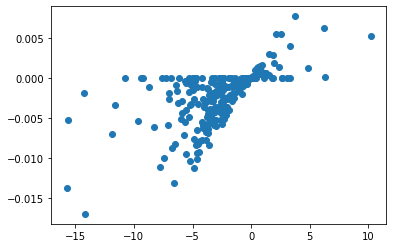

In [49]:
plt.scatter(o2_offset, pH_impact)

In [15]:
np.nanmean(argo_n['pH_O2_ADJUST_LIPHR'] - argo_n['pH_orig_LIPHR'])

-0.0034289946721787214

In [10]:
print(np.mean(glodap_offsets.DOXY_ADJUSTED_offset))
print(np.nanmedian(glodap_offsets.DOXY_ADJUSTED_offset))

plt.figure(figsize=(20,12))
plt.hist(glodap_offsets.DOXY_ADJUSTED_offset, bins=np.linspace(-400, 400, 401))

plt.xlabel('DOXY Offset')
plt.savefig(output_dir_figs + 'Glodap_offsets_doxy_plus_minus_400.png')


NameError: name 'glodap_offsets' is not defined

Looking at impact of oxygen offsets on pH / pCO2 / Nitrate / DIC

In [4]:
# load glodap_offsets with cal info:

glodap_offsets = xr.load_dataset(output_dir+'glodap_offsets_withcalibration.nc')

In [5]:
#create meta groups based on calibration groups (air cal, no air cal, no cal)
g = glodap_offsets.o2_calib_group.copy(deep=True)
g = g.where(glodap_offsets.o2_calib_group == 'air cal','not air')
glodap_offsets['o2_calib_air'] = xr.where(glodap_offsets.o2_calib_group=='bad','no cal',g)

glodap_offsets['o2_calib_air_key'] = xr.where(glodap_offsets.o2_calib_air=='air cal',1,0)

glodap_offsets['o2_not_air_key'] = xr.where(glodap_offsets.o2_calib_air=='not air',-1,0)
glodap_offsets['o2_cal_key'] = glodap_offsets['o2_calib_air_key'] + glodap_offsets['o2_not_air_key']

wmo_means = glodap_offsets.groupby('main_float_wmo').mean(...)

In [6]:
# new dataset of air_cal floats only
a = wmo_means.where(wmo_means.o2_cal_key>0.6, drop=True)

In [55]:
# checking for inconsistencies in interpolated vs. derived lengths

pH_count = 0;
# load float files, use offset information to calculate impact 
for n in range(2,3): #range(0, len(a.main_float_wmo)):
    wmo_n = int(a.main_float_wmo[n].values)
    
    argo_derived_n = xr.load_dataset(argo_path+ 'derived/' + str(wmo_n) + '_derived.nc')

    print(str(n) + ': ' + str(a.main_float_wmo[n].values))

    print(argo_wmo[wmo_n].PRES_ADJUSTED.shape)
    print(argo_derived_n.PRES_ADJUSTED.shape)
    print(' ')
    

2: 1901362
(36, 951)
(18, 78)
 


In [64]:
argo_derived_n.PRES_ADJUSTED[0,:]

<xarray.DataArray 'PRES_ADJUSTED' (N_LEVELS: 78)>
array([   6.7     ,   10.9     ,   15.9     ,   21.1     ,   25.900002,
         30.900002,   35.3     ,   40.7     ,   45.4     ,   50.4     ,
         60.3     ,   70.2     ,   80.2     ,   90.299995,  100.7     ,
        110.6     ,  120.2     ,  129.9     ,  140.      ,  150.5     ,
        189.59999 ,  200.8     ,  210.3     ,  220.5     ,  230.4     ,
        240.8     ,  250.09999 ,  260.      ,  270.      ,  280.6     ,
        290.7     ,  300.2     ,  310.6     ,  320.2     ,  330.      ,
        340.      ,  350.40002 ,  374.90002 ,  400.7     ,  425.30002 ,
        450.5     ,  475.      ,  500.6     ,  524.9     ,  550.      ,
        575.2     ,  600.5     ,  625.3     ,  650.3     ,  674.9     ,
        700.3     ,  750.8     ,  800.60004 ,  849.8     ,  900.10004 ,
        950.2     , 1000.60004 , 1049.7     , 1099.5     , 1150.      ,
       1200.      , 1250.7999  , 1300.      , 1349.8999  , 1400.      ,
       1450.2999  , 1500.2999  , 1549.8999  , 1600.1     , 1650.2     ,
       1700.2999  , 1750.3999  , 1800.3999  , 1850.2     , 1900.3999  ,
       1950.1     ,         nan,         nan], dtype=float32)
Dimensions without coordinates: N_LEVELS

In [62]:
argo_wmo[wmo_n].TEMP_ADJUSTED[:,0]

<xarray.DataArray 'TEMP_ADJUSTED' (N_PROF: 36)>
array([5.958705, 6.061573, 5.986551, 6.152714, 5.939236, 6.016245, 6.049644,
       6.164514, 6.204602, 6.236   , 6.153162, 6.296157, 6.23022 , 6.24085 ,
       6.243927, 6.233834, 6.328376, 6.32239 , 5.958705, 6.061573, 5.986551,
       6.152714, 5.939236, 6.016245, 6.049644, 6.164514, 6.204602, 6.236   ,
       6.153162, 6.296157, 6.23022 , 6.24085 , 6.243927, 6.233834, 6.328376,
       6.32239 ])
Dimensions without coordinates: N_PROF

In [45]:
LIPHR_path = liar_dir

pH_count = 0;
# load float files, use offset information to calculate impact 
for n in range(37,38): #range(0, len(a.main_float_wmo)):
    wmo_n = int(a.main_float_wmo[n].values)
    
    argo_derived_n = xr.load_dataset(argo_path+ 'derived/' + str(wmo_n) + '_derived.nc')

    # check if the float also has pH
    if 'PH_IN_SITU_TOTAL_ADJUSTED' in argo_derived_n.keys() and np.any(~np.isnan(argo_derived_n.PH_IN_SITU_TOTAL_ADJUSTED)):
        pH_count = pH_count+1
        print(str(n) + ': ' + str(a.main_float_wmo[n].values))

    else:
        continue
    
    nprof = argo_derived_n.LATITUDE.shape[0]

    #test_pH = np.empty(nprof, dtype=float)
    
    # initialize coordinate and measurement arrays
    Coordinates_all = np.empty([nprof, 3],dtype=float)
    Coordinates_all[:] = np.nan
       
    Measurements_all = np.empty([nprof, 4],dtype=float)
    Measurements_all[:] = np.nan
    
    MeasIDVec = [1, 7, 3, 6]
    for p in range(nprof):
        index_1500 = argo_wmo[wmo_n].PRES_ADJUSTED[p,:]==1500

        #argo_wmo[5904659].PSAL_ADJUSTED[0,index_1500]
        Coordinates_all[p,:] = np.stack((argo_wmo[wmo_n].LONGITUDE[p].values.flatten(), 
                            argo_wmo[wmo_n].LATITUDE[p].values.flatten(), 
                            argo_wmo[wmo_n].PRES_ADJUSTED[p,index_1500].values.flatten()),
                            axis=1)
        Measurements_all[p,:] = np.stack((argo_wmo[wmo_n].PSAL_ADJUSTED[p,index_1500].values.flatten(), 
                             argo_wmo[wmo_n].TEMP_ADJUSTED[p,index_1500].values.flatten(), 
                             argo_wmo[wmo_n].NITRATE_ADJUSTED[p,index_1500].values.flatten(), 
                             argo_wmo[wmo_n].DOXY_ADJUSTED[p,index_1500].values.flatten()),
                             axis=1)
    
    
    # calculate LIPHR pH for all profiles
    test_pH = carbon_utils.LIPHR_matlab(LIPHR_path,
                                    Coordinates_all.tolist(),
                                    Measurements_all.tolist(),
                                    MeasIDVec, 
                                    OAAdjustTF = False)  
       
    Measurements_o2_offset = np.concatenate(([Measurements_all[:,0]], 
                                  [Measurements_all[:,1]],
                                  [Measurements_all[:,2]],
                                  [Measurements_all[:,3]] + a.DOXY_ADJUSTED_offset[n].values))
    Measurements_o2_offset = np.transpose(Measurements_o2_offset)
    # calculate LIPHR pH for all profiles
    new_pH = carbon_utils.LIPHR_matlab(LIPHR_path,
                                    Coordinates_all.tolist(),
                                    Measurements_o2_offset.tolist(),
                                    MeasIDVec, 
                                    OAAdjustTF = False)  
    argo_derived_n['pH_orig_LIPHR'] = (['N_PROF'],np.empty(argo_derived_n.PRES_ADJUSTED.shape[0])) #nprof x nlevel
    argo_derived_n.pH_orig_LIPHR[:] = test_pH[:,0]

    argo_derived_n['pH_O2_ADJUST_LIPHR'] = (['N_PROF'],np.empty(argo_derived_n.PRES_ADJUSTED.shape[0])) #nprof x nlevel
    argo_derived_n.pH_O2_ADJUST_LIPHR[:] = new_pH[:,0]
    # difference between pH_O2_orig_LIPHR and PH_IN_SITU_TOTAL_ADJUSTED- should that average 0? 
    # Impact of O2 can be seen in the test_pH minus new_pH average 
    
    argo_derived_n['PH_IN_SITU_TOTAL_ADJUSTED_w_O2_ADJUST_OFFSET'] = \
        argo_derived_n.PH_IN_SITU_TOTAL_ADJUSTED + np.mean(new_pH - test_pH)
    
    argo_derived_n.to_netcdf(argo_path+ 'derived/' + str(wmo_n) + '_derived_2.nc')


37: 5904659


In [46]:
argo_wmo[5904659]

<xarray.Dataset>
Dimensions:                    (N_PROF: 153, N_LEVELS: 951)
Dimensions without coordinates: N_PROF, N_LEVELS
Data variables: (12/20)
    wmo                        (N_PROF) int64 5904659 5904659 ... 5904659
    profile                    (N_PROF) float64 ...
    juld                       (N_PROF) datetime64[ns] ...
    LATITUDE                   (N_PROF) float64 ...
    LONGITUDE                  (N_PROF) float64 ...
    num_var                    (N_PROF) float64 ...
    ...                         ...
    spice                      (N_PROF, N_LEVELS) float64 ...
    PRES_ADJUSTED              (N_PROF, N_LEVELS) float64 ...
    DIC                        (N_PROF, N_LEVELS) float64 ...
    TALK_LIAR                  (N_PROF, N_LEVELS) float64 ...
    pCO2                       (N_PROF, N_LEVELS) float64 ...
    pCO2_pH_corr               (N_PROF, N_LEVELS) float64 ...

In [47]:
argo_derived_n

        #call CO2sys to calculate pCO2 with bias correction and no O2 correction (check against original)
        results = pyco2.sys(
                par1=argo_derived_n.TALK_LIAR, 
                par2=argo_derived_n.pH_insitu_corr,
                par1_type=1,
                par2_type=3,
                temperature=argo_n.TEMP_ADJUSTED, 
                pressure=argo_n.PRES_ADJUSTED, 
                salinity=argo_n.PSAL_ADJUSTED, 
                temperature_out=25.* np.ones(argo_n.PRES_ADJUSTED.shape), #fixed 25C temperature
                pressure_out=argo_n.PRES_ADJUSTED,
                total_silicate=SI,
                total_phosphate=PO4,
                opt_pH_scale = 1, #total
                opt_k_carbonic=10, #Lueker et al. 2000
                opt_k_bisulfate=1, # Dickson 1990 (Note, matlab co2sys combines KSO4 with TB. option 3 = KSO4 of Dickson & TB of Lee 2010)
                opt_total_borate=2, # Lee et al. 2010
                opt_k_fluoride=2, # Perez and Fraga 1987
                opt_buffers_mode=1,
                )

<xarray.Dataset>
Dimensions:                                       (N_PROF: 153, N_LEVELS: 558)
Dimensions without coordinates: N_PROF, N_LEVELS
Data variables: (12/22)
    wmo                                           int64 5904659
    CYCLE_NUMBER                                  (N_PROF) float64 1.0 ... 153.0
    LONGITUDE                                     (N_PROF) float64 -55.38 ......
    LATITUDE                                      (N_PROF) float64 -59.64 ......
    JULD_LOCATION                                 (N_PROF) datetime64[ns] 201...
    TEMP_ADJUSTED                                 (N_PROF, N_LEVELS) float32 ...
    ...                                            ...
    TALK_LIAR                                     (N_PROF, N_LEVELS) float64 ...
    pCO2                                          (N_PROF, N_LEVELS) float64 ...
    pCO2_pH_corr                                  (N_PROF, N_LEVELS) float64 ...
    pH_orig_LIPHR                                 (N_PROF) float64 7.88 ... 7...
    pH_O2_ADJUST_LIPHR                            (N_PROF) float64 7.875 ... ...
    PH_IN_SITU_TOTAL_ADJUSTED_w_O2_ADJUST_OFFSET  (N_PROF, N_LEVELS) float32 ...

-0.0036396733963356244

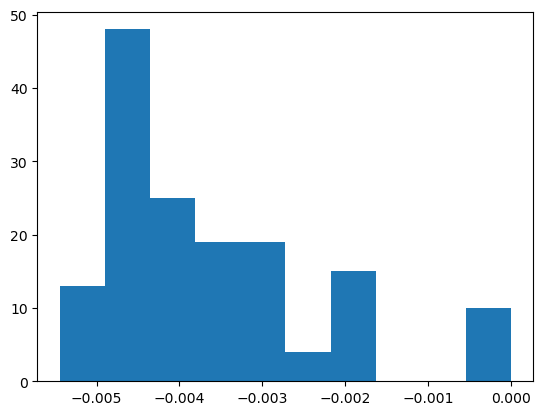

In [209]:
test_pH - new_pH
plt.hist(new_pH - test_pH)
np.mean(new_pH - test_pH)

<xarray.DataArray 'PH_IN_SITU_TOTAL_ADJUSTED' ()>
array(0.00315701)

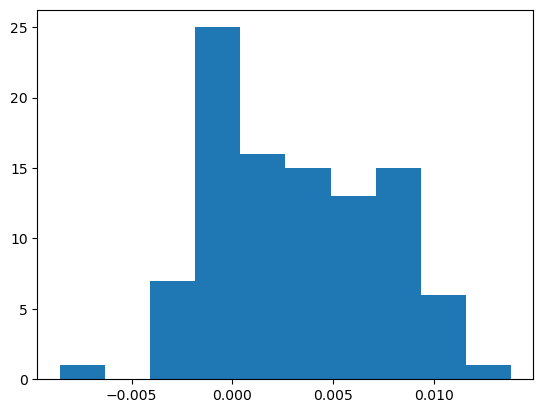

In [154]:
plt.hist(argo_wmo[wmo_n].PH_IN_SITU_TOTAL_ADJUSTED[:,index_1500] - test_pH)
np.mean(argo_wmo[wmo_n].PH_IN_SITU_TOTAL_ADJUSTED[:,index_1500] - test_pH)